# Лабораторная работа №2 по дисциплине "Технологии обеспечения информационной безопасности"

## Тема: Анализ логов

Выполнил Сердюков Матвей, группа ББМО-01-23

Вариант №1: `32 mod 16 + 1 = 1`

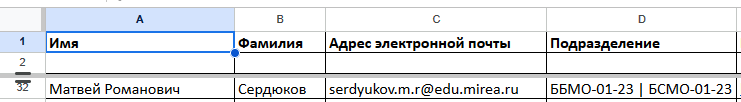

Ноутбук идемпотентен - он может быть многократно выполнен целиком сочетанием клавиш `Ctrl+F9` или пунктом меню "Среда выполнения" -> "Выполнить все"

### Клонирование репозитория с логами для их последующего анализа

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 563 (delta 58), reused 54 (delta 48), pack-reused 476
Receiving objects: 100% (563/563), 7.32 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (259/259), done.


### Задание регулярного выражения для парсинга логов

Пояснение к регулярному выражению:

Типичная запись лога Android выглядит следующим образом:

```
03-17 16:13:38.928  2227  2227 I StackScrollAlgorithm: updateDimmedActivatedHideSensitive overlap:false
```

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

- Дата - два двузначных числа, отделённых дефисом: `(\d{2}-\d{2})`
- Время в формате `HH:MM:SS.SSS`: `(\d{2}:\d{2}:\d{2}\.\d{3})`
- PID - ID процесса, целое число: `(\d+)`
- TID - ID потока, целое число: `(\d+)`
- Уровень логирования - одна из 5 возможных букв, каждая из которых соответствует определённому уровню: **I**nfo, **D**ebug, **V**erbose, **W**arning, **E**rror: `([IDVWE])`
- Компонент - имя компонента, создавшего запись в логе, отделённое от сообщения двоеточием: `(\w+):`
- Сообщение - непосредственное содержание записи, все символы до конца строки: `(.*)`

In [ ]:
import re

pattern = r'(\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2}\.\d{3})\s+(\d+)\s+(\d+)\s+([IDVWE])\s+(\w+):\s(.*)'

### Инициализация базы данных

В среде выполнения создаётся каталог `./db`, где будет храниться файл базы данных SQLite

In [ ]:
![ -d db ] || mkdir db

In [ ]:
import sqlite3

# путь к файлу с БД
db_path = './db/log-analysis.db'

# подключение к БД
connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

# очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime text, pid int, tid int, msg_type text, component text, message text)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

### Парсинг лога и сохранение записей в БД

In [ ]:
# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# очистка таблицы во избежание дублирования данных
cursor.execute("DELETE FROM logs")

# парсинг файла с логом
with open('./loghub/Android/Android_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = "2023-" + log_match.group(1) # добавление года для соответствия формату ISO8601
            time = log_match.group(2)
            datetime = f"{date} {time}" # формирование полной даты по формату ISO8601
            pid = log_match.group(3) # ID процесса
            tid = log_match.group(4) # ID потока
            msg_type = log_match.group(5) # уровень логирования
            component = log_match.group(6)
            message = log_match.group(7)
            values = (datetime, pid, tid, msg_type, component, message) # создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (datetime, pid, tid, msg_type, component, message) VALUES (?, ?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # запись данных в БД

connection.commit()
cursor.close()
connection.close()

### Чтение записей из БД

In [ ]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("id", "Time", "PID", "TID", "Log level", "Component", "Message"))
log_df

,id,Time,PID,TID,Log level,Component,Message
0,1,2023-03-17 16:13:38.811,1702,2395,D,WindowManager,printFreezingDisplayLogsopening app wtoken = A...
1,2,2023-03-17 16:13:38.819,1702,8671,D,PowerManagerService,"acquire lock=233570404, flags=0x1, tag=""View L..."
2,3,2023-03-17 16:13:38.820,1702,8671,D,PowerManagerService,"ready=true,policy=3,wakefulness=1,wksummary=0x..."
3,4,2023-03-17 16:13:38.839,1702,2113,V,WindowManager,Skipping AppWindowToken{df0798e token=Token{78...
4,5,2023-03-17 16:13:38.859,2227,2227,D,TextView,visible is system.time.showampm
...,...,...,...,...,...,...,...
1995,1996,2023-03-17 16:16:08.840,1702,1820,I,DisplayPowerController,HBM brightnessOut =38
1996,1997,2023-03-17 16:16:08.840,1702,1820,D,DisplayPowerController,"Animating brightness: target=38, rate=200"
1997,1998,2023-03-17 16:16:09.141,1702,1820,I,DisplayPowerController,HBM brightnessIn =38
1998,1999,2023-03-17 16:16:09.141,1702,1820,I,DisplayPowerController,HBM brightnessOut =38


### Построение графика распределения уровней логирования

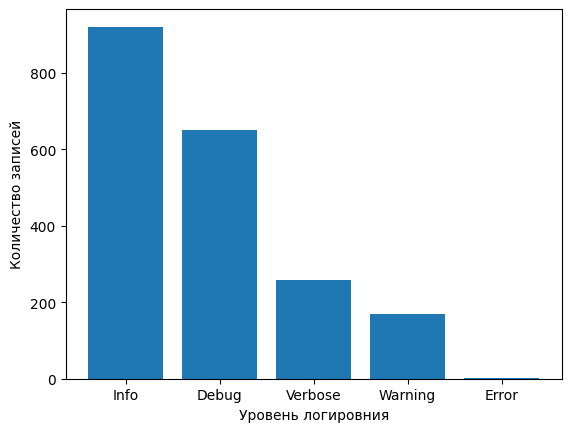

In [ ]:
import matplotlib.pyplot as plt

# подсчёт записей с различными уровнями логирования
log_level_distrib = log_df['Log level'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

# более подробные заголовки для графика
verbose_xticks = ["Info", "Debug", "Verbose", "Warning", "Error"]

plt.xticks([0,1,2,3,4], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Уровень логировния')
plt.ylabel('Количество записей')
plt.bar(x,y)

plt.show()

### Построение графика распределения записей по компонентам, создавшим запись

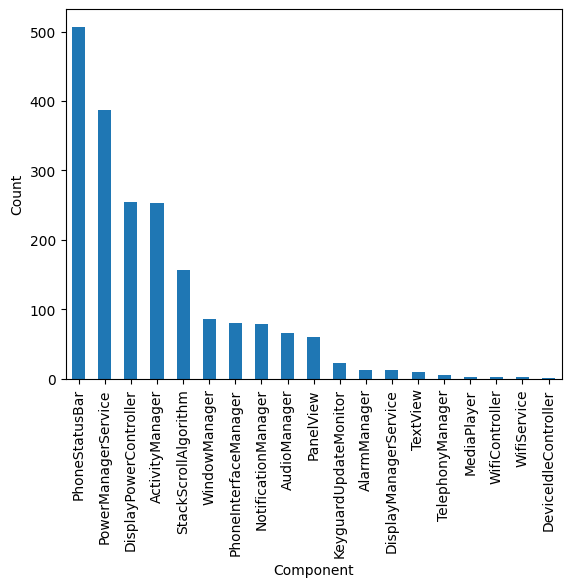

In [ ]:
# подсчёт записей с различными уровнями логирования
components_distrib = log_df['Component'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Component')
plt.ylabel('Count')
plt.show()

### Построение графика распределения предупреждений за время логирования (сообщений с уровнем логирования 'W')

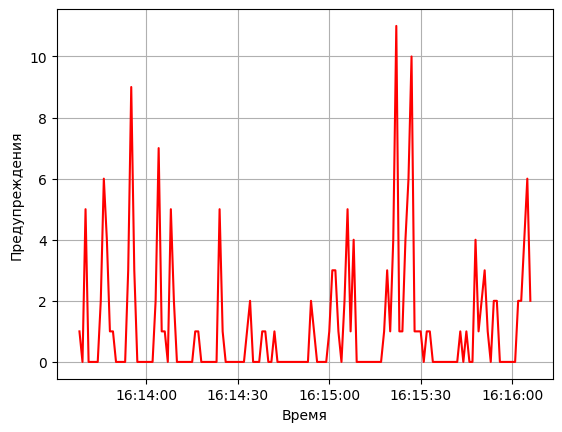

In [ ]:
# выборка записей-предупреждений
warning_df = log_df[log_df['Log level'] == 'W'].copy()

# конвертация времени в объект datetime
warning_df['Time'] = pd.to_datetime(warning_df['Time'])

# группировка по времени
warning_count = warning_df.groupby('Time').size()

# ресэмплинг для группировки по целым секундам для наглядности
warning_count = warning_count.resample('S').sum()
warning_count = warning_count.fillna(0)

plt.plot(warning_count.index, warning_count.values, linestyle='-', color='r')
plt.xlabel('Время')
plt.ylabel('Предупреждения')
plt.grid(True)
plt.show()